In [1]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.plan_a.transformer import MarketSampleTransformer, MarketSampleDataset, TabTransformer
from etrade.spot.forecast.plan_a.simulator4 import PredictBasedMarketSimulator

from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

In [2]:
market_len = 4
init_kwargs = {
    "aq_constructor": OrdinaryGaussianKernelDistributionConstructor((0, 50), (1, 10), (1, 2)),
    "dp_constructor": OrdinaryGaussianKernelDistributionConstructor((0, 10), (1, 2), (1, 2)),
    "rp_constructor": OrdinaryGaussianKernelDistributionConstructor((0, 20), (1, 4), (1, 2)),
    "aq_range": (0, 50),
    "dp_range": (0, 1e+6),
    "rp_range": (0, 1e+6),
    "predict_weight": numpy.full((3, market_len), 1),
    "noise_weight_range": ((0.01, 0.05), (0.01, 0.05), (0.01, 0.05)),
    "market_len": market_len
}

station = Station("station", 50)
br = BasicRecycle(0.5, 1.05)
simulator = PredictBasedMarketSimulator(**init_kwargs)

In [3]:
aq, dp, rp = simulator.predicted_random(1000)

[28.715591712364795, 22.913246902595603, 11.591339020210409, 33.333211393637214]
[50.0, 0.0, 0.0, 50.0]
0.9655338902880802


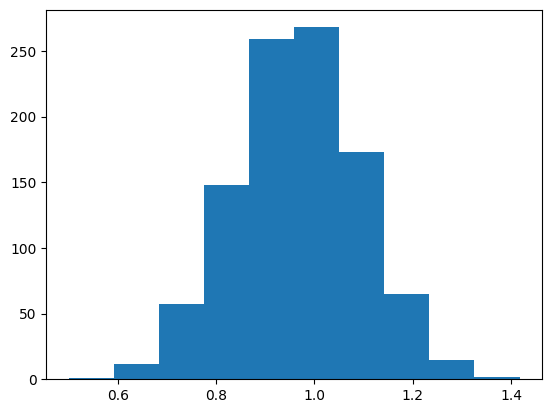

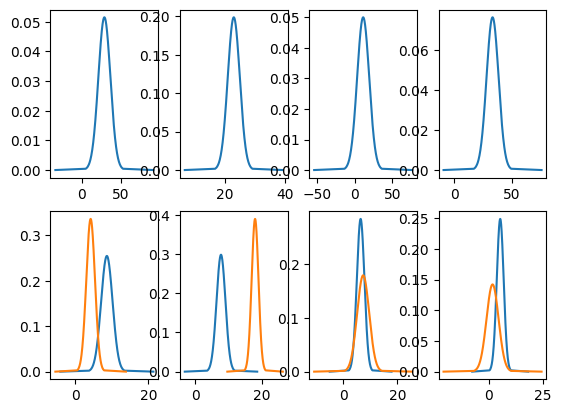

In [4]:
x = simulator.random_sample_optimize(station, br, aq, dp, rp)
print(numpy.mean(aq, axis=1).tolist())
print(x.tolist())

print(
    numpy.sum(numpy.mean(aq, axis=1)) / numpy.sum(x)
)

pyplot.hist(numpy.sum(aq, axis=0) / numpy.sum(x))
pyplot.show()

simulator.predict_market.plot2(1, 1000)

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


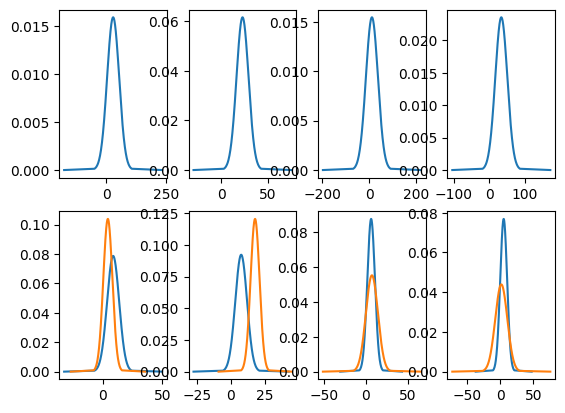

In [5]:
real_market = simulator.new_divergenced_market(js_divergence=(0.2,0.2,0.2))
real_market.plot2(1, 1000)

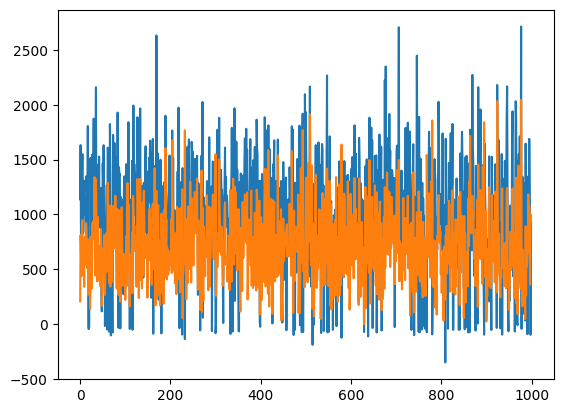

In [6]:
real_aq, real_dp, real_rp = real_market.rvf(1000, simulator.aq_range, simulator.dp_range, simulator.rp_range)
pyplot.plot(simulator.random_sample_trade(x, station, br, real_aq, real_dp, real_rp))
pyplot.plot(simulator.random_sample_trade(real_aq, station, br, real_aq, real_dp, real_rp))
pyplot.show()